## Resultados de clasificación

Presentamos los resultados de clasificación para los modelos analizados

- GPT-3.5
- Cohere/Aya
- Mixtral
- BETO -- modelo finetuneado



In [1]:

%load_ext autoreload
%autoreload 2
from rioplatense_hs.openai import get_completion
import pandas as pd
from glob import glob
pd.options.display.max_colwidth = 1000
#df_train.loc[df_train["LGBTI"] > 0, ["title", "text", "text_label"]].sample(20)

files = {
    #"one-shot": sorted(glob("../data/test*pred*1shot.csv")),
    "gpt-3.5": sorted(glob("../data/test*pred*12shot.csv")),
    "beto": sorted(glob("../data/test*beto.csv")),
    "aya": sorted(glob("../data/test*aya_.csv")),
    "mixtral": sorted(glob("../data/test*mixtral.csv")),
}

assert len({len(value) for value in files.values()}) == 1

dfs = {k: pd.concat([pd.read_csv(f, index_col=0) for f in v]) for k, v in files.items()}


In [2]:
{k: v.shape for k, v in dfs.items()}

{'gpt-3.5': (5670, 24),
 'beto': (5670, 22),
 'aya': (5670, 25),
 'mixtral': (5670, 25)}

In [3]:
from rioplatense_hs.preprocessing import text_to_label, labels
from sklearn.metrics import classification_report

pred_labels = [f"PRED_{label}" for label in labels]
score_labels = [f"SCORE_{label}" for label in labels]

dfs["beto"][score_labels] = dfs["beto"][pred_labels]
dfs["beto"][pred_labels] = (dfs["beto"][pred_labels] > 0.5).astype(int)

In [4]:
from rioplatense_hs.preprocessing import labels as all_labels
labels = ["WOMEN", "LGBTI", "RACISM", "CLASS"]

model_order = ["aya", "gpt-3.5", "mixtral", "beto"]
pred_labels = [f"PRED_{label}" for label in labels]

all_pred_labels = [f"PRED_{label}" for label in all_labels]

In [9]:
from tqdm.auto import tqdm
from confidence_intervals import Bootstrap
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = []

for name, df in dfs.items():
    print(name)
    for label in tqdm(labels):

        for metric in {"precision", "recall", "f1"}:
            if metric == "precision":
                score = precision_score
            elif metric == "recall":
                score = recall_score
            elif metric == "f1":
                score = f1_score


            gold_labels = df[label].values
            preds = df[f"PRED_{label}"].values

            bst = Bootstrap(metric=score, num_bootstraps=150)

            bst_scores = bst.run(preds, gold_labels)

            for score in bst_scores:
                metrics.append(
                    {
                        "model": name,
                        "label": label,
                        "metric": metric,
                        "score": score,
                    }
                )


gpt-3.5


  0%|          | 0/4 [00:00<?, ?it/s]

beto


  0%|          | 0/4 [00:00<?, ?it/s]

aya


  0%|          | 0/4 [00:00<?, ?it/s]

mixtral


  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
df_metrics = pd.DataFrame(metrics)

df_metrics

,model,label,metric,score
0,gpt-3.5,WOMEN,precision,0.3286
1,gpt-3.5,WOMEN,precision,0.3293
2,gpt-3.5,WOMEN,precision,0.3006
3,gpt-3.5,WOMEN,precision,0.3409
4,gpt-3.5,WOMEN,precision,0.3006
...,...,...,...,...
7195,mixtral,CLASS,f1,0.2649
7196,mixtral,CLASS,f1,0.1970
7197,mixtral,CLASS,f1,0.2755
7198,mixtral,CLASS,f1,0.1721


In [ ]:
df_metrics.to_csv("../results/full_results.csv", index=False)

In [11]:
pd.options.display.float_format = "{:.4f}".format

pd.options.display.max_rows = 100


f1s = df_metrics[df_metrics["metric"] == "f1"]


f1s.groupby(["model", "label", "metric"]).agg(["mean", "std"])

score       
                        mean    std
model   label  metric              
aya     CLASS  f1     0.1171 0.0167
        LGBTI  f1     0.2283 0.0333
        RACISM f1     0.4883 0.0225
        WOMEN  f1     0.1808 0.0189
beto    CLASS  f1     0.5775 0.0520
        LGBTI  f1     0.4575 0.0510
        RACISM f1     0.7471 0.0218
        WOMEN  f1     0.4299 0.0424
gpt-3.5 CLASS  f1     0.3448 0.0404
        LGBTI  f1     0.5365 0.0467
        RACISM f1     0.6099 0.0259
        WOMEN  f1     0.3169 0.0346
mixtral CLASS  f1     0.2376 0.0293
        LGBTI  f1     0.5357 0.0430
        RACISM f1     0.5801 0.0246
        WOMEN  f1     0.2508 0.0290

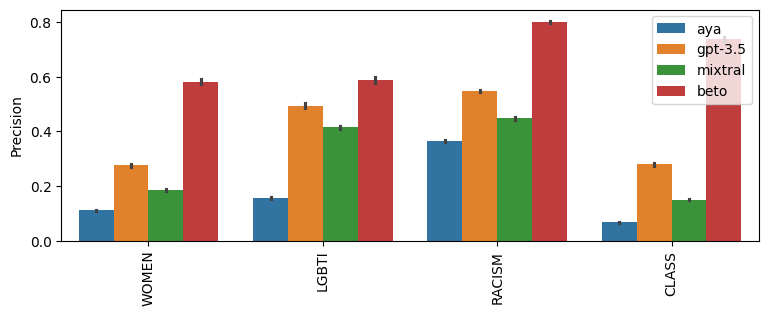

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

def plot_metric(metric, labels, legend=True):
    plt.figure(figsize=(9, 3))

    sub_df = df_metrics[(df_metrics["metric"] == metric) & (df_metrics["label"].isin(labels))]

    sns.barplot(x='label', y='score', hue='model', data=sub_df, hue_order=model_order)


    # Set the plot title and labels
    plt.xlabel('')
    plt.ylabel(metric.capitalize())

    # Show the plot

    # Remove xticks

    #plt.xticks(ticks=[])
    plt.xticks(rotation=90)
    # Make legend smaller
    if legend:
        plt.legend(loc='upper right')#, bbox_to_anchor=(0.35, 1.03))


metric = "precision"
plot_metric(metric, all_labels)
plt.savefig(f"img/{metric}.png", bbox_inches='tight', dpi=300)

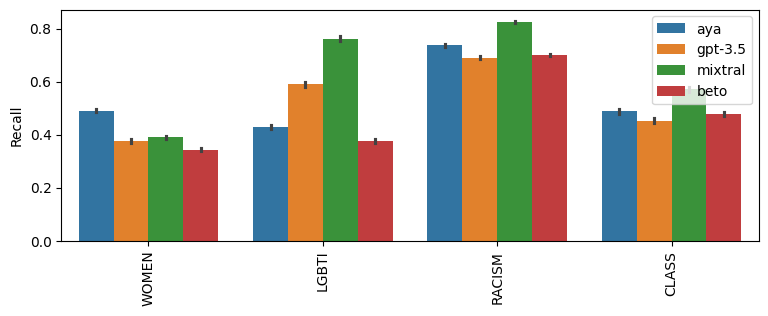

In [13]:
plot_metric("recall", all_labels)
plt.savefig(f"img/recall.png", bbox_inches='tight', dpi=300)

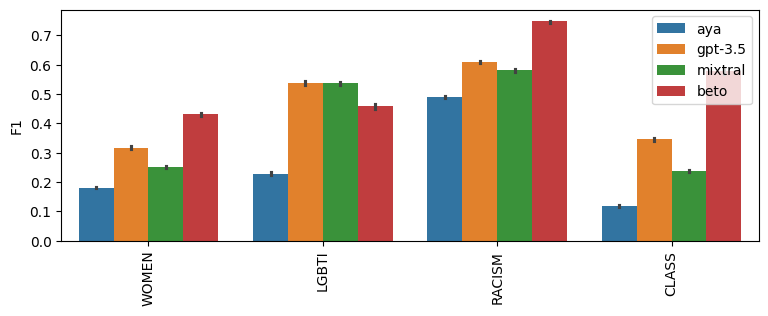

In [14]:
plot_metric("f1", all_labels)
plt.savefig(f"img/f1.png", bbox_inches='tight', dpi=300)

In [16]:
# Just keep the most important characteristics

hate_metrics = []

# If set to True, uses all labels. If not, only WOMEN, LGBTI, RACISM, CLASS
evaluate_all = False


for name, df in dfs.items():
    if not evaluate_all:
        label_hate = df[labels].sum(axis=1) > 0
        pred_hate = df[pred_labels].sum(axis=1) > 0
    else:
        label_hate = df[all_labels].sum(axis=1) > 0
        pred_hate = df[all_pred_labels].sum(axis=1) > 0
    for metric in {"precision", "recall", "f1"}:
        if metric == "precision":
            score = precision_score
        elif metric == "recall":
            score = recall_score
        elif metric == "f1":
            score = f1_score


        gold_labels = label_hate.values
        preds = pred_hate.values

        bst = Bootstrap(metric=score, num_bootstraps=150)

        bst_scores = bst.run(preds, gold_labels)

        for score in bst_scores:
            hate_metrics.append(
                {
                    "model": name,
                    "metric": metric,
                    "score": score,
                }
            )

hate_metrics = pd.DataFrame(hate_metrics)

hate_metrics

,model,metric,score
0,gpt-3.5,precision,0.4404
1,gpt-3.5,precision,0.4539
2,gpt-3.5,precision,0.4614
3,gpt-3.5,precision,0.4480
4,gpt-3.5,precision,0.4221
...,...,...,...
1795,mixtral,f1,0.4365
1796,mixtral,f1,0.4534
1797,mixtral,f1,0.4576
1798,mixtral,f1,0.4079


([0, 1, 2], [Text(0, 0, 'precision'), Text(1, 0, 'recall'), Text(2, 0, 'f1')])

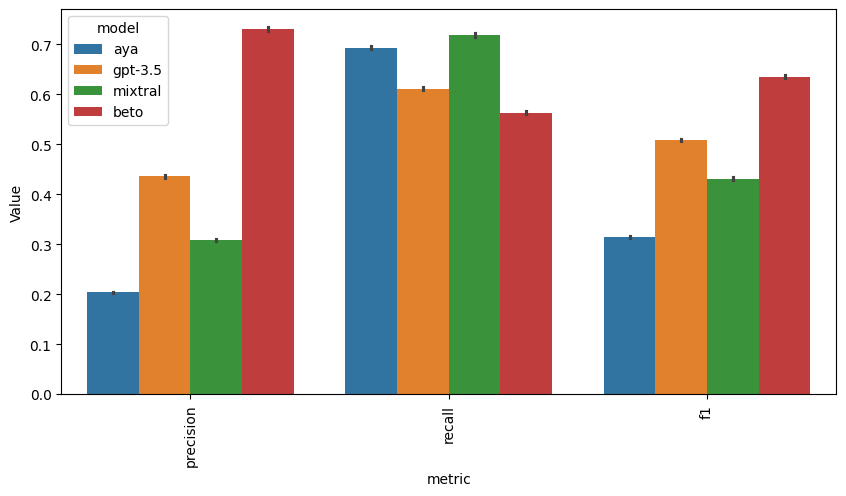

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the barplot

plt.figure(figsize=(10, 5))
sns.barplot(x='metric', y='score', hue='model', data=hate_metrics, hue_order=model_order)


plt.ylabel('Value')

# Show the plot

plt.xticks(rotation=90)
#plt.show()

In [26]:

# Show as mean +/- std
metrics_copy = hate_metrics.copy()

metrics_copy["score"] *= 100

res = metrics_copy.groupby(["model", "metric"]).mean().round(1).astype(str) + " \pm " + metrics_copy.groupby(["model", "metric"]).std().round(1).astype(str)

res

score
model   metric                 
aya     f1         31.4 \pm 1.3
        precision  20.3 \pm 0.9
        recall     69.3 \pm 2.3
beto    f1         63.5 \pm 1.8
        precision  72.9 \pm 2.4
        recall     56.3 \pm 2.1
gpt-3.5 f1         50.9 \pm 1.7
        precision  43.6 \pm 1.8
        recall     61.1 \pm 2.2
mixtral f1         43.1 \pm 1.4
        precision  30.8 \pm 1.3
        recall     71.8 \pm 2.2

In [27]:
# Convert metrics to columns

print(res.reset_index().pivot(index="model", columns="metric", values="score").to_latex())

\begin{tabular}{llll}
\toprule
metric & f1 & precision & recall \\
model &  &  &  \\
\midrule
aya & 31.4 \pm 1.3 & 20.3 \pm 0.9 & 69.3 \pm 2.3 \\
beto & 63.5 \pm 1.8 & 72.9 \pm 2.4 & 56.3 \pm 2.1 \\
gpt-3.5 & 50.9 \pm 1.7 & 43.6 \pm 1.8 & 61.1 \pm 2.2 \\
mixtral & 43.1 \pm 1.4 & 30.8 \pm 1.3 & 71.8 \pm 2.2 \\
\bottomrule
\end{tabular}



## LGBTI 

BETO vs few-shot ChatGPT

In [29]:
# Merge dfs['few-shot'] and dfs['beto']

columns_to_drop = [
    "title", "text", "context_tweet", "HATEFUL", "CALLS", "WOMEN", "LGBTI", "RACISM", "CLASS", "POLITICS", "DISABLED", "CRIMINAL", "APPEARANCE",
    "PRED_CALLS", "PRED_POLITICS", "PRED_DISABLED", "PRED_CRIMINAL", "PRED_APPEARANCE",
]



df_join = dfs["gpt-3.5"].join(dfs["beto"].drop(columns_to_drop, axis=1), rsuffix="_beto")

cols = [c for c in df_join.columns if c.isupper() and "SCORE" not in c]

df_join[cols] = df_join[cols].astype(bool)

Ejemplos que falla BETO y acierta ChatGPT y eran LGBTI

In [30]:
df_join.columns

Index(['title', 'text', 'context_tweet', 'HATEFUL', 'CALLS', 'WOMEN', 'LGBTI',
       'RACISM', 'CLASS', 'POLITICS', 'DISABLED', 'APPEARANCE', 'CRIMINAL',
       'prompt', 'pred_cot', 'PRED_WOMEN', 'PRED_LGBTI', 'PRED_RACISM',
       'PRED_CLASS', 'PRED_POLITICS', 'PRED_DISABLED', 'PRED_APPEARANCE',
       'PRED_CRIMINAL', 'PRED_HATEFUL', 'PRED_WOMEN_beto', 'PRED_LGBTI_beto',
       'PRED_RACISM_beto', 'PRED_CLASS_beto', 'SCORE_WOMEN', 'SCORE_LGBTI',
       'SCORE_RACISM', 'SCORE_CLASS', 'SCORE_POLITICS', 'SCORE_DISABLED',
       'SCORE_APPEARANCE', 'SCORE_CRIMINAL'],
      dtype='object')

In [31]:
df_join.loc[df_join["LGBTI"] & df_join["PRED_LGBTI"] & ~df_join["PRED_LGBTI_beto"]][["context_tweet", "text", "pred_cot", "SCORE_LGBTI"]]

,context_tweet,text,pred_cot,SCORE_LGBTI
id,,,,
405355,Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario https://t.co/M0K3NXgfA8,@usuario En la autopsia no debe figurar la próstata por ley! 😄,"El texto hace una referencia burlona a la identidad de género de la mujer trans y a la eliminación de su próstata. La respuesta final es ""lgbti"".",0.061692
405366,Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario https://t.co/M0K3NXgfA8,@usuario Salió de caño... cuac!,"El texto hace referencia a que la mujer trans ""salió de caño"", lo cual es un término despectivo relacionado a la identidad de género. La respuesta final es ""lgbti"".",0.001594
327760,Los infectados en villas porteñas crecieron un 80% en cuatro días https://t.co/8Cc7pgnSzG https://t.co/iOpldGjWAz,"@usuario Ojalá que el virus penetre más en las villas y maten a todos esos delincuentes que viven ahi, hay paraguayos narcos, bolivianos que traen la droga de bolivia, y gente de mala vida. También hay travas que van a trabajar de noche a palermo.","El texto alude a las personas que viven en villas como delincuentes, menciona nacionalidades específicas (paraguayos, bolivianos) de manera despectiva y hace referencia a travestis como parte de un estereotipo negativo. La respuesta final es ""clase, criminal, lgbti"".",0.017190
405362,Tras una ráfaga de más de 20 disparos asesinaron a una mujer trans en Rosario https://t.co/M0K3NXgfA8,@usuario Cómo no saco su escopeta y aplicó la defensa propia?!,"El texto alude a que la mujer trans debería haber utilizado una escopeta para defenderse y evitar su asesinato. La respuesta final es ""lgbti, criminal"".",0.010081
390770,″¿Por qué un beso entre dos hombres los vuelve tan violentos?”: la vida después de haber sido víctima de ataques homofóbicos | Por Milton Del Moral https://t.co/MgHNMf8Sch,@usuario Porque es desagradable,"El texto expresa su desagrado hacia el beso entre dos hombres, lo cual puede considerarse como homofobia. La respuesta final es ""lgbti"".",0.018116
397546,Así luce el actor Elliot Page tras declararse trans https://t.co/yeTGhw6ooT,@usuario Che... Qué diferencia hay entre Trans y un Trabuco??,"El texto se refiere despectivamente a las personas trans y hace una comparación ofensiva. La respuesta final es ""lgbti"".",0.126789
395337,"El exabrupto de Jair Bolsonaro sobre Brasil y el Covid-19: ""Tienen que dejar de ser un país de maricas"" https://t.co/WtxRjY7tJp",@usuario Ser zurdo es de marica! Revienten cagones!,"El texto alude a la homosexualidad como algo negativo y utiliza el término ""marica"" como un insulto. La respuesta final es ""lgbti"".",0.163100
390767,″¿Por qué un beso entre dos hombres los vuelve tan violentos?”: la vida después de haber sido víctima de ataques homofóbicos | Por Milton Del Moral https://t.co/MgHNMf8Sch,@usuario Será xq va contra la naturaleza de la raza...,"El texto alude a que un beso entre dos hombres va en contra de la ""naturaleza de la raza"", insinuando que la homosexualidad no es natural. La respuesta final es ""lgbti, racismo"".",0.005803
398935,Mara Gómez: la historia de la primera futbolista trans en el torneo argentino https://t.co/rBx3pMPUbB https://t.co/l5I1j0xFku,@usuario Para mi tendrían q ser todas trans así juegan bien a la pelota. Son inmirables los partidos. Ojalá haya 100% de trans en el fútbol femenino.\nVamos Mara. \n\nFirma: los espectadores,"El texto alude a que las futbolistas trans juegan bien a la pelota y sugiere que deberían ser todas trans en el fútbol femenino. Además, se refiere a los espectadores como firmantes de esta declaración. La respuesta final es ""lgbti"".",0.332832
